# Wind Power Forecasting with fbprophet

### Project goals 
**to come up with a  long term wind forecasting technique required to predict the wind power that could be generated from a windmill**.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statsmodels
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa import stattools
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set()

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [215]:
from prophet import Prophet

In [212]:
# python -m pip install prophet
# pip install ipywidgets
# import prophet

### Load the cleaned data
- the resampled hourly and daily dataset**

### fbprophet does not accept the datetime, so we will only use the daily data, and not the hourly data

In [264]:
#putting the data in the required format for fbprophet
df = pd.read_csv('../data/daily_averages.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['ds'] = df['datetime'].dt.date
df = df[['ds', 'daily_av']]
df.columns = ['ds', 'y']

In [265]:
df

,ds,y
0,2018-01-01,190.815478
1,2018-01-02,339.470285
2,2018-01-03,317.517653
3,2018-01-04,361.856700
4,2018-01-05,236.783611
...,...,...
815,2020-03-26,644.979144
816,2020-03-27,718.695340
817,2020-03-28,666.476157
818,2020-03-29,793.461992


In [266]:
# instantiating and fitting the model
m = Prophet()
m.fit(df)


22:12:41 - cmdstanpy - INFO - Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing


In [270]:
future = m.make_future_dataframe(periods=200)
future.tail()

,ds
1015,2020-10-12
1016,2020-10-13
1017,2020-10-14
1018,2020-10-15
1019,2020-10-16


In [271]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1015,2020-10-12,212.885260,-129.428255,546.197405
1016,2020-10-13,221.873170,-99.377784,536.714458
1017,2020-10-14,245.020732,-104.237875,571.326542
1018,2020-10-15,269.375427,-55.525714,604.922530
1019,2020-10-16,226.563374,-115.766663,558.649486


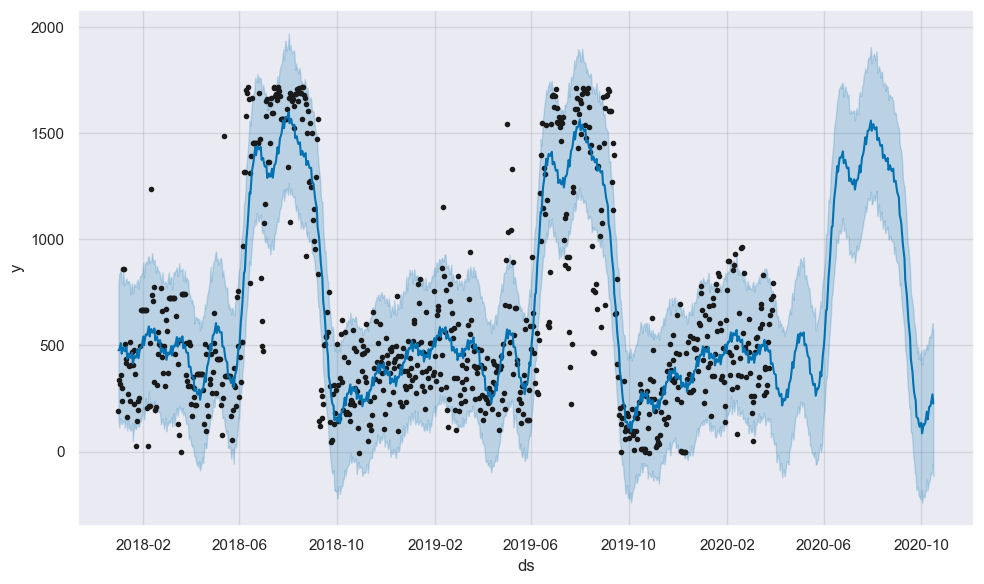

In [272]:
fig1 = m.plot(forecast)

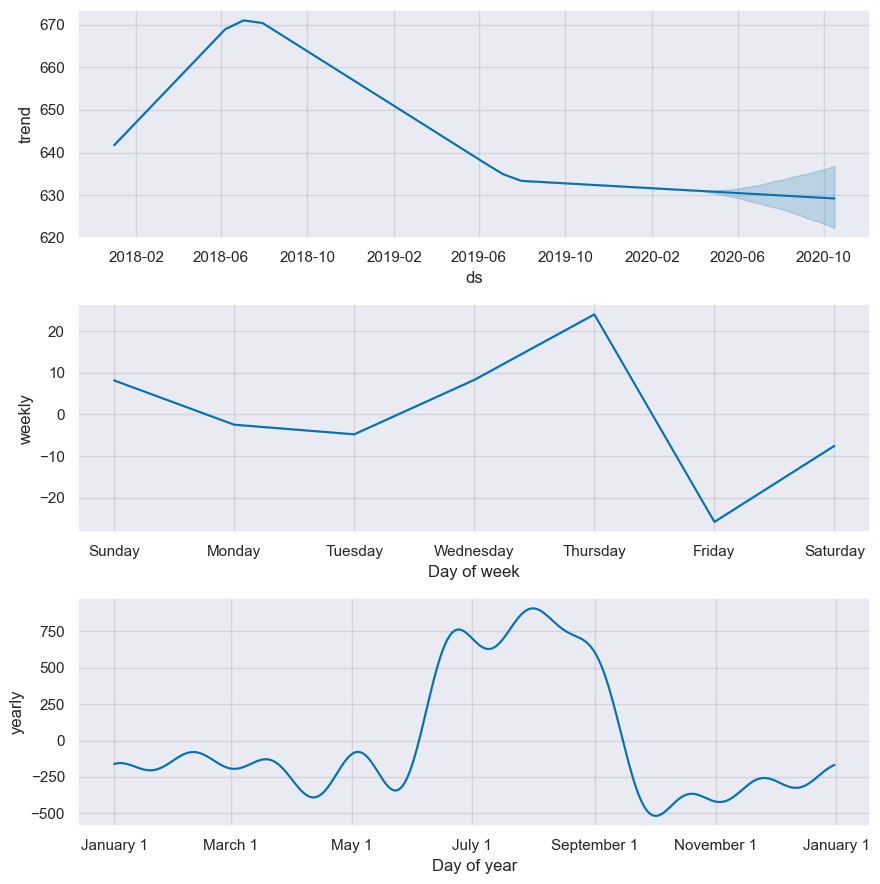

In [273]:
fig2 = m.plot_components(forecast)

In [274]:
from prophet.plot import plot_plotly, plot_components_plotly


In [275]:
plot_plotly(m, forecast)

NameError: name 'go' is not defined

In [2]:
hourly_av = pd.read_csv('../data/hourly_averages.csv', index_col=0)
daily_av = pd.read_csv('../data/daily_averages.csv', index_col=0)
daily_av.head()

,windspeed,daily_av
datetime,,
2018-01-01 00:00:00+00:00,3.866226,190.815478
2018-01-02 00:00:00+00:00,4.677844,339.470285
2018-01-03 00:00:00+00:00,4.520639,317.517653
2018-01-04 00:00:00+00:00,5.063196,361.856700
2018-01-05 00:00:00+00:00,4.391144,236.783611


In [3]:
hourly_av.head()

,windspeed,hourly_av
datetime,,
2018-01-01 00:00:00+00:00,2.097677,-5.091432
2018-01-01 01:00:00+00:00,1.954781,-4.822549
2018-01-01 02:00:00+00:00,1.704621,-4.668977
2018-01-01 03:00:00+00:00,1.913003,-5.262396
2018-01-01 04:00:00+00:00,2.180540,-5.600275


### Split the data into train test

In [4]:
# split the hourly dataset
training_size = int(len(hourly_av)*0.80)
test_size = len(hourly_av)-training_size

train_hourly, test_hourly = train_test_split(hourly_av, train_size=training_size)
y_train_hourly=train_hourly['hourly_av']
y_test_hourly=test_hourly['hourly_av']
#y_train, y_test, X_train, X_test = \
#    model_selection.train_test_split(y, X, test_size=20)
print(f'the shapes of the y_train and y_test hourly data: {y_train_hourly.shape, y_test_hourly.shape}')

# the daily dataset
training_size = int(len(daily_av)*0.80)
test_size = len(daily_av)-training_size

train_daily, test_daily = train_test_split(daily_av, train_size=training_size)
y_train_daily=train_daily['daily_av']
y_test_daily=test_daily['daily_av']
print(f'the shapes of the y_train and y_test daily data: {y_train_daily.shape, y_test_daily.shape}')

the shapes of the y_train and y_test hourly data: ((15744,), (3936,))
the shapes of the y_train and y_test daily data: ((656,), (164,))


In [5]:
# I also create data arrays of the full dataset for the target column before the split
y_full_hourly = hourly_av['hourly_av']
y_full_daily = daily_av['daily_av']
print(f'the shapes of the y_full daily and hourly data is: {y_full_hourly.shape, y_full_daily.shape}')

the shapes of the y_full daily and hourly data is: ((19680,), (820,))


In [116]:
x=y_train_daily.index

## ARIMA 
- ARiMA-based models can achieve decent scores on most time-series problems and  well-suited as a baseline model.
-  our data is not stationary, but we want to see how a standard ARIMA model will perform

### Model Selection using Autocorrelation and Partial Autocorrelation plots

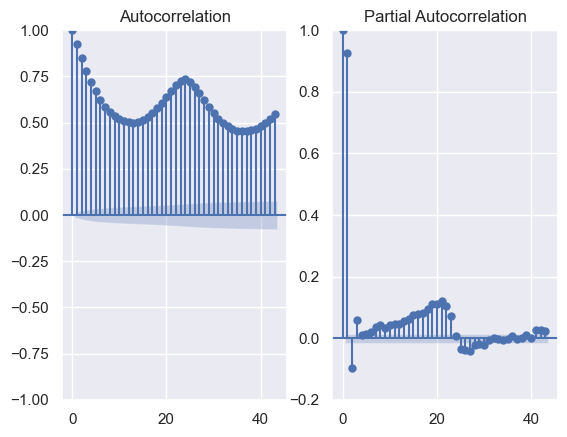

In [24]:
# hourly data
fig, ax = plt.subplots(1,2, sharex=True)
plot_acf(y_full_hourly, ax=ax[0])
# plt.ylim(-0.2, 1)
plot_pacf(y_full_hourly, method='ywm', ax=ax[1])
plt.ylim(-0.2, 1);

- from the plots above, it appears the data is best modelled by an ARIMA(p,d,q) process,
- p and q cannot be inferred from the plots in such a case, 
- iterrative approaches such as auto-arima is thus recommended to help find the best model

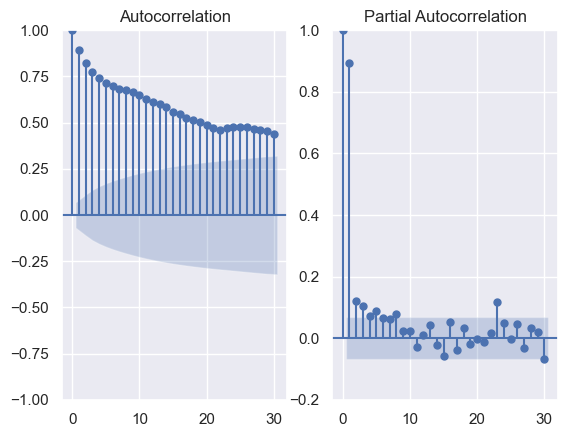

In [23]:
fig, ax = plt.subplots(1,2)
plot_acf(y_full_daily, ax=ax[0])
plt.ylim(-0.2, 1)
plot_pacf(y_full_daily, method='ywm', ax=ax[1])
plt.ylim(-0.2, 1)
plt.show()

###  Statsmodels ar_select_order -also helps in selecting lags

In [25]:
selected_order_h = ar_select_order(y_full_hourly, maxlag = 15)
print(f"For the hourly data, the lag we need to include are {selected_order_h.ar_lags}")
selected_order_d = ar_select_order(y_full_daily, maxlag = 15)
print(f"For the daily data, the lag we need to include are {selected_order_d.ar_lags}")

For the hourly data, the lag we need to include are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
For the daily data, the lag we need to include are [1, 2, 3]


C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### ARIMA base model

In [6]:
# on hourly means
arima_base_h = ARIMA(endog= y_full_hourly, order = (1,1,0)).fit()
hourly_av['arima_base_h'] = arima_base_h.predict()

C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


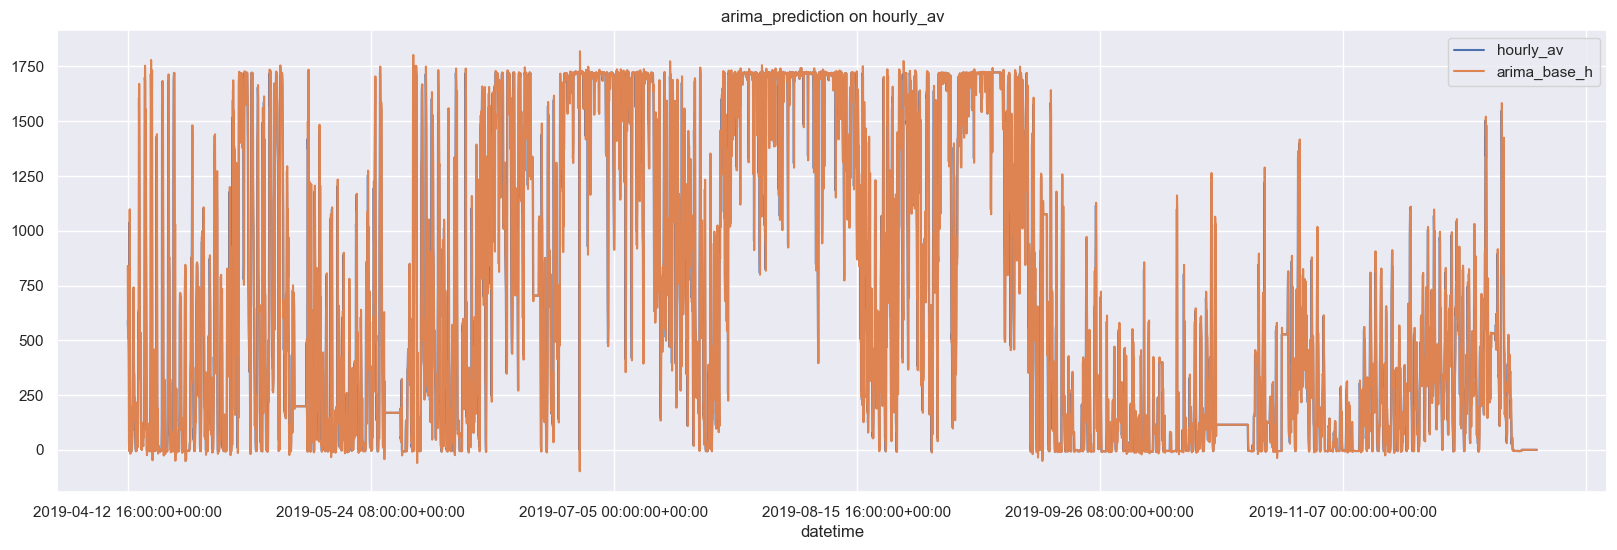

In [40]:
hourly_av[['hourly_av', 'arima_base_h']][11200:17000].plot(figsize = (20, 6)).set_title("arima_base prediction on hourly_av");

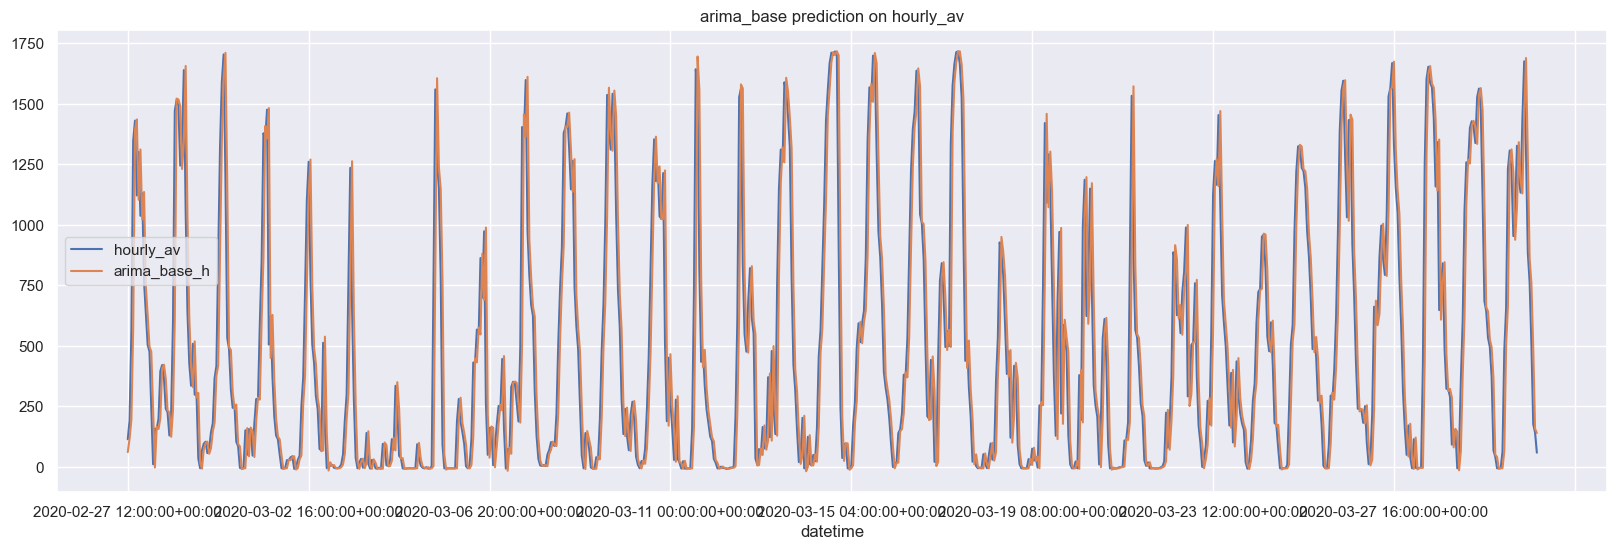

In [8]:
hourly_av[['hourly_av', 'arima_base_h']][18900:19800].plot(figsize = (20, 6)).set_title("arima_base prediction on hourly_av");

In [9]:
# on daily means
arima_base_d= ARIMA(endog= y_full_daily, order = (3,1,0)).fit()
daily_av['arima_base_d'] = arima_base_d.predict()

C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


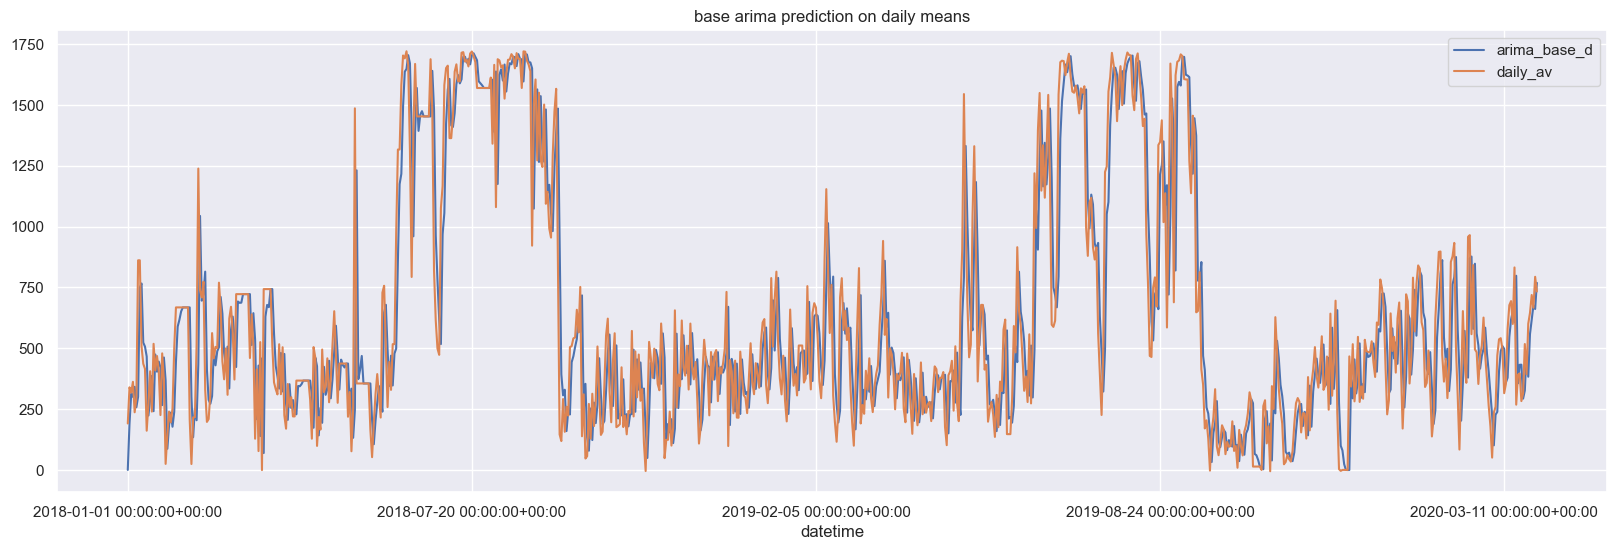

In [10]:
daily_av[['arima_base_d', 'daily_av']][:830].plot(figsize = (20, 6)).set_title("base arima prediction on daily means");

### ARIMA Model Selection using Auto-ARIMA from the pmdarima package**
- provides for an automatic parameter search for the optimal values/ parameters of the model

In [11]:
#Standard ARIMA Model on hourly means -without seasonal comp.
pmARIMA_model_h = pm.auto_arima(y_full_hourly,
                              start_p=1, start_q=1, test='adf', # use adftest to find optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='warn', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True)
forecast_pmARIMA_model_h = pmARIMA_model_h.predict()  # make your forecasts

In [14]:
#Standard ARIMA Model on daily means -without seasonal comp.
pmdARIMA_model_d = pm.auto_arima(y_full_daily, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
forecast_pmdARIMA_model_d = pmdARIMA_model_d.predict()  # make your forecasts

### Evaluate the model

In [42]:
from sklearn.metrics import mean_absolute_error
arima_error = round(mean_absolute_error(hourly_av['hourly_av'], hourly_av['arima_base_h']),2)
print(f'Mean absolute error on the hourly data for the ARIMA base model {arima_error}')
arima_error = round(mean_absolute_error(daily_av['daily_av'], daily_av['arima_base_d']),2)
print(f'Mean absolute erroron the daily data for the ARIMA base model {arima_error}')

Mean absolute error on the hourly data for the ARIMA base model 126.46
Mean absolute erroron the daily data for the ARIMA base model 155.51


### Model Diagnostics
- Four plots result from the plot_diagnostics function. 
- for a good fit 
    - no obvious patterns in the residuals
    - KDE curve -very similar to the normal distribution 
    - Most of the data points should lie on the straight line
    -95% of correlations for lag greater than zero not significant.

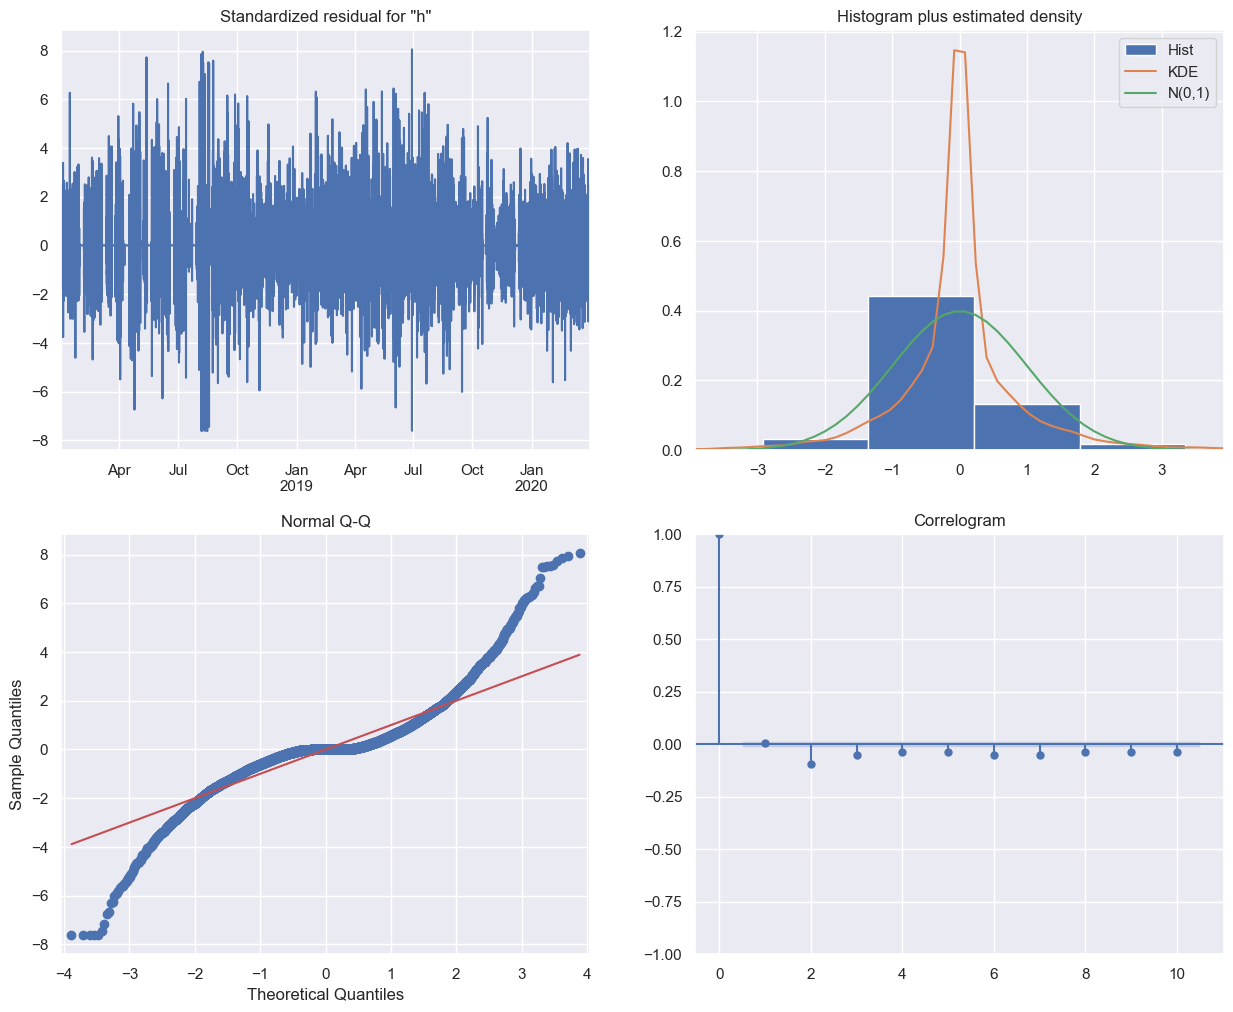

In [29]:
arima_base_h.plot_diagnostics(figsize=(15,12));

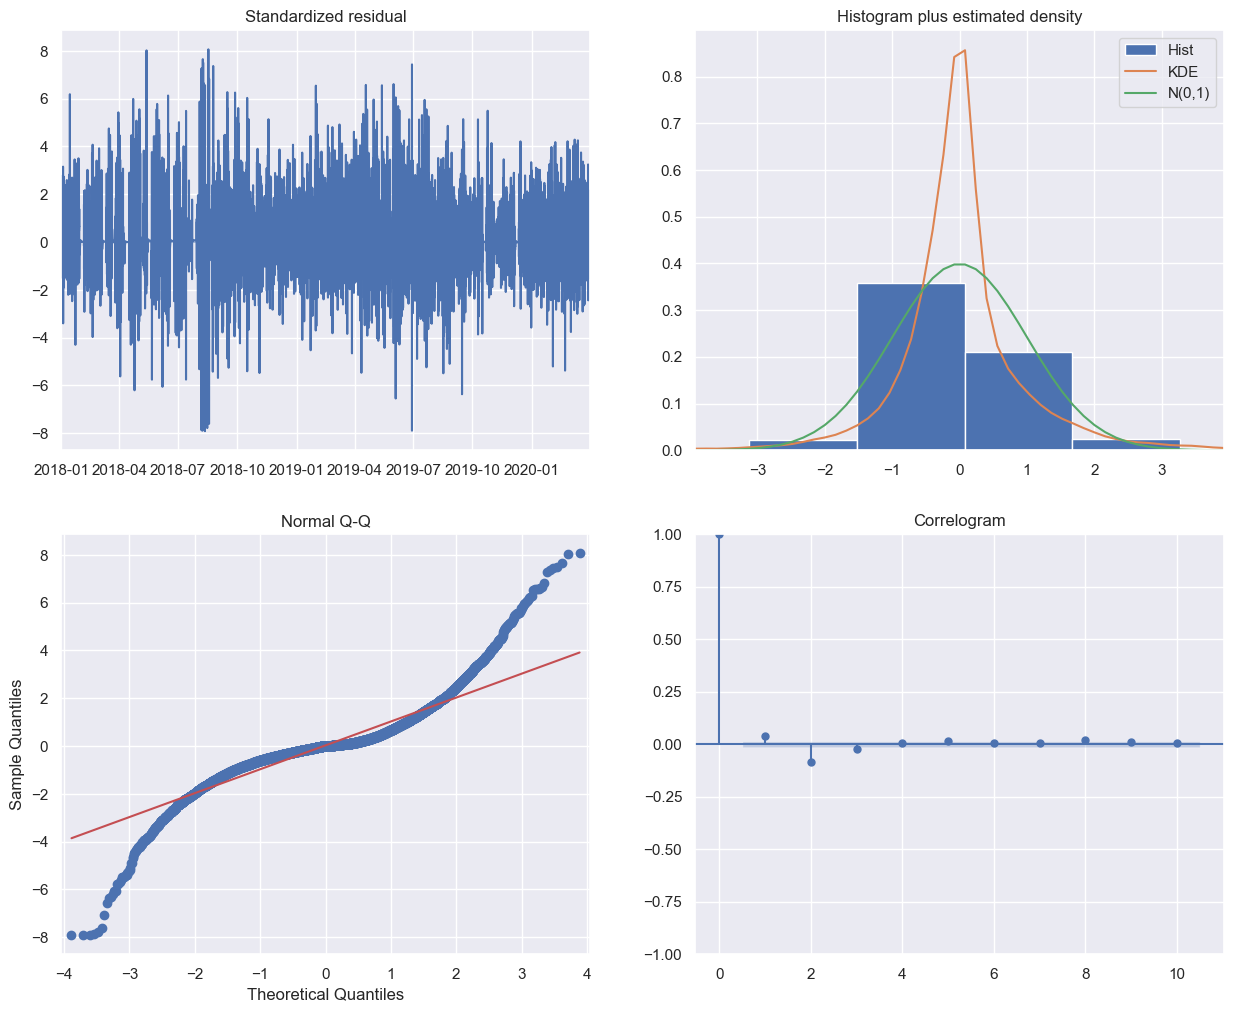

In [28]:
pmARIMA_model_h.plot_diagnostics(figsize=(15,12));

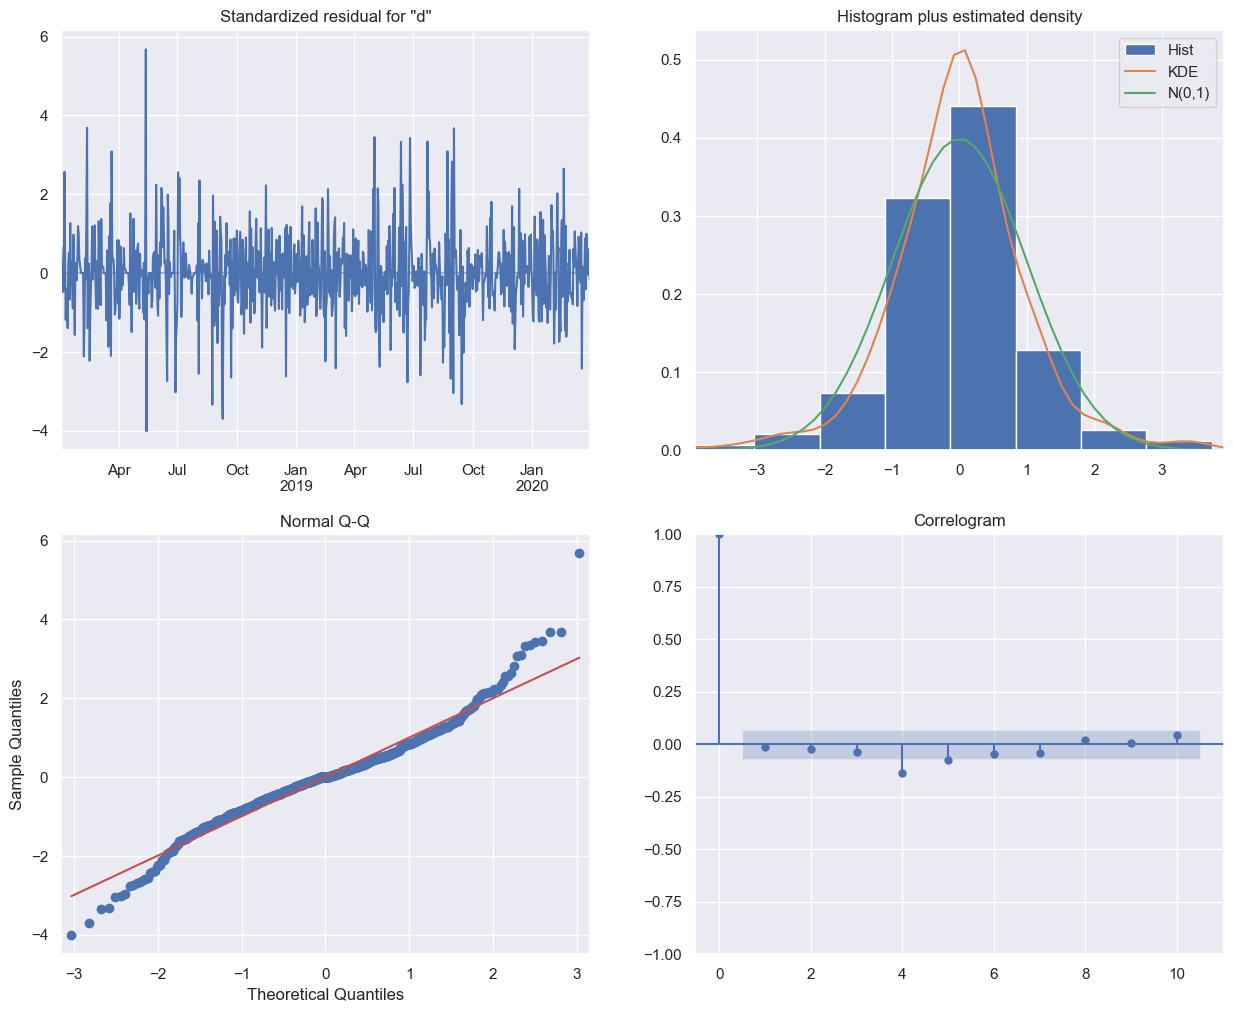

In [27]:
arima_base_d.plot_diagnostics(figsize=(15,12));

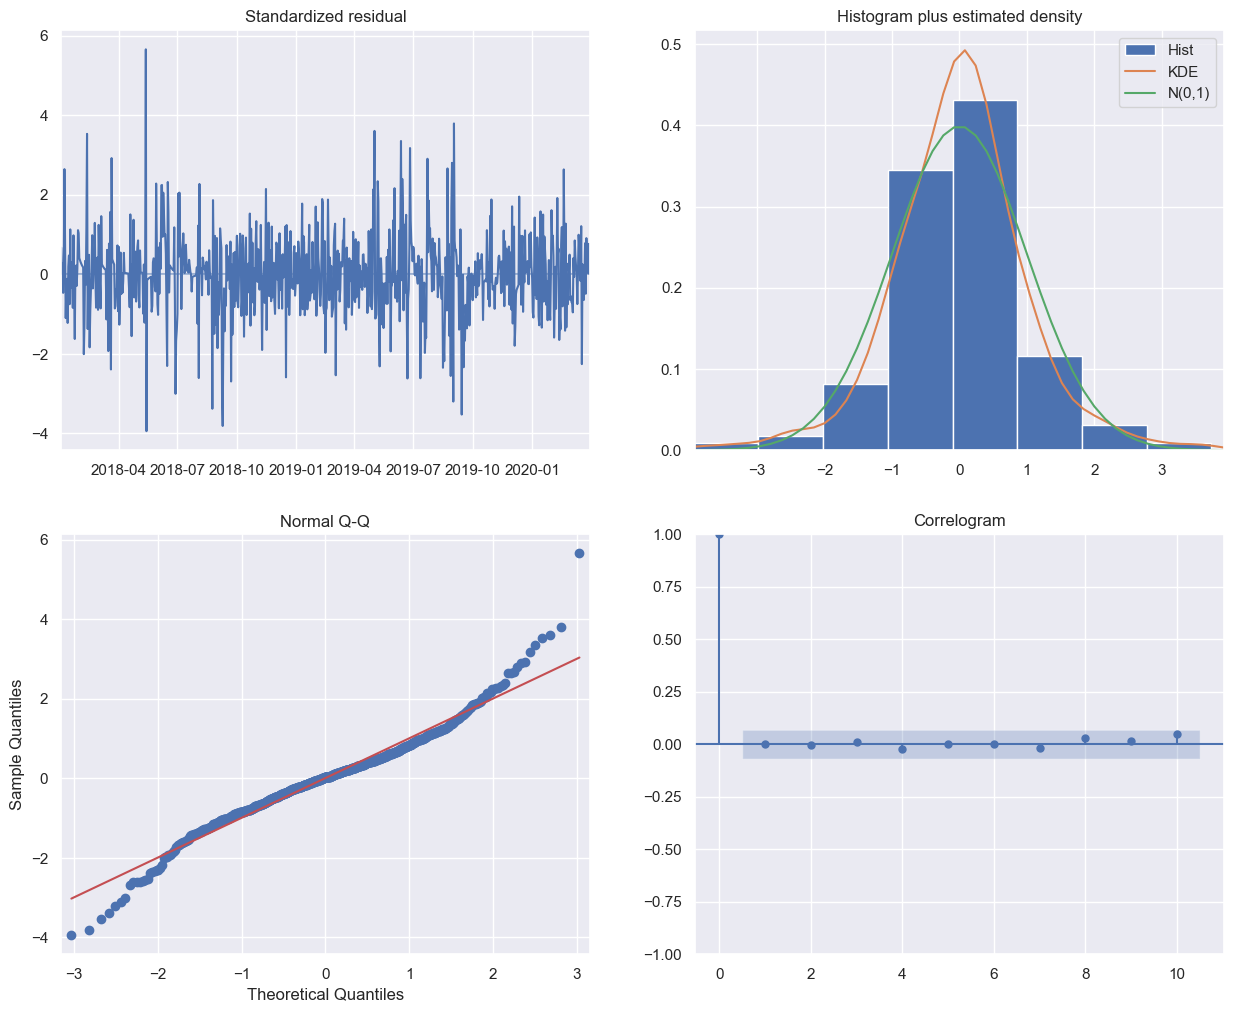

In [30]:
pmdARIMA_model_d.plot_diagnostics(figsize=(15,12));

### Forecasts

In [147]:
y_full_hourly.shape

(19680,)

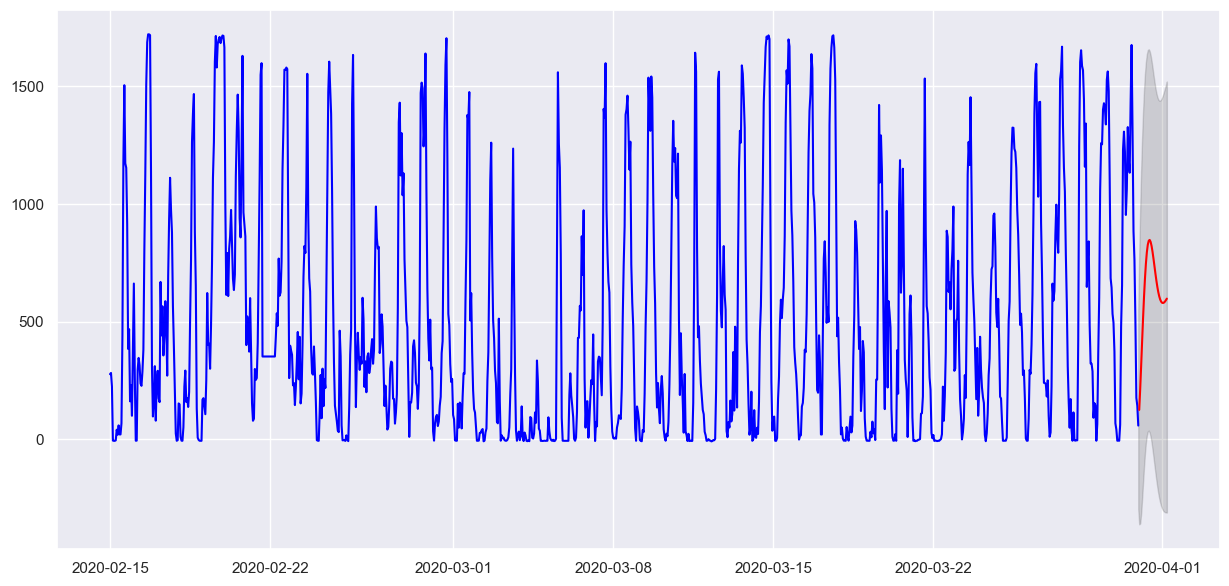

In [156]:
fitted, confint = pmARIMA_model_h.predict(n_periods=31, return_conf_int=True)
index_of_fc = pd.date_range(y_full_hourly.index[-1], periods = 31, freq='H', tz='utc')
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
y_full_hourly.index = pd.to_datetime(y_full_hourly.index)
X = y_full_hourly.index.append(index_of_fc)
plt.figure(figsize=(15,7))
plt.plot(X[18600:19680], y_full_hourly[18600:19680], c='blue')
plt.plot(X[19680:], fitted_series, color='red')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15);

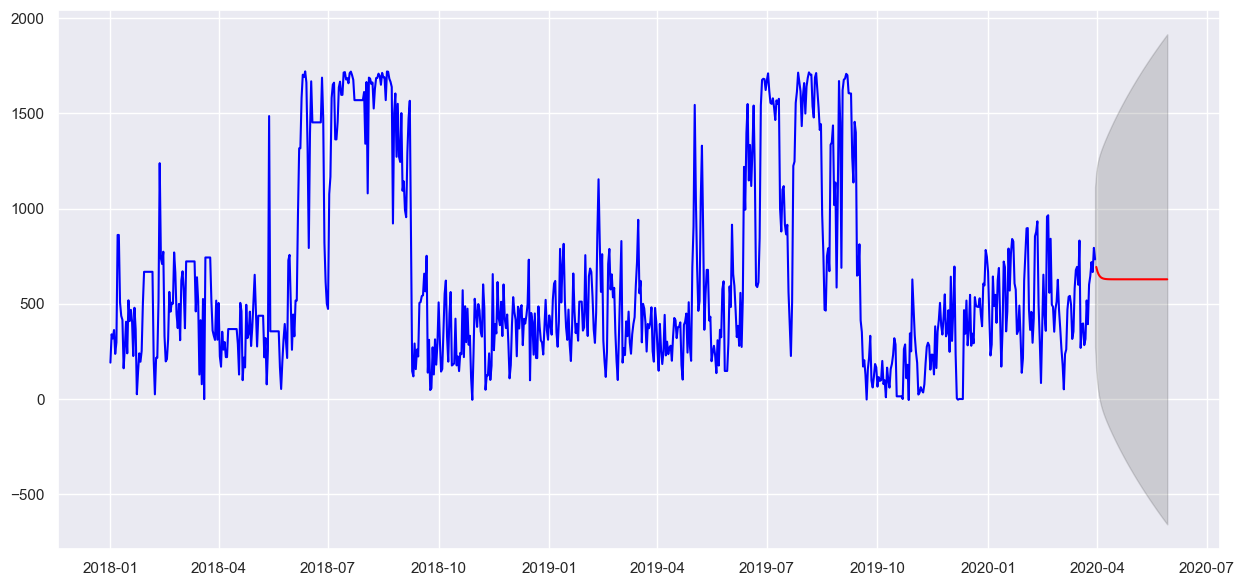

In [157]:
fitted, confint = pmdARIMA_model_d.predict(n_periods=61, return_conf_int=True)
index_of_fc = pd.date_range(y_full_daily.index[-1], periods = 61, freq='D', tz='utc')
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
y_full_daily.index = pd.to_datetime(y_full_daily.index)
X = y_full_daily.index.append(index_of_fc)
plt.figure(figsize=(15,7))
plt.plot(X[:820], y_full_daily, c='blue')
plt.plot(X[820:], fitted_series, color='red')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15);

In [146]:
#forecasts = pmdARIMA_model_d.predict(y_test_daily.shape[0])  # predict N steps into the future

TypeError: tz must be string or tzinfo subclass.

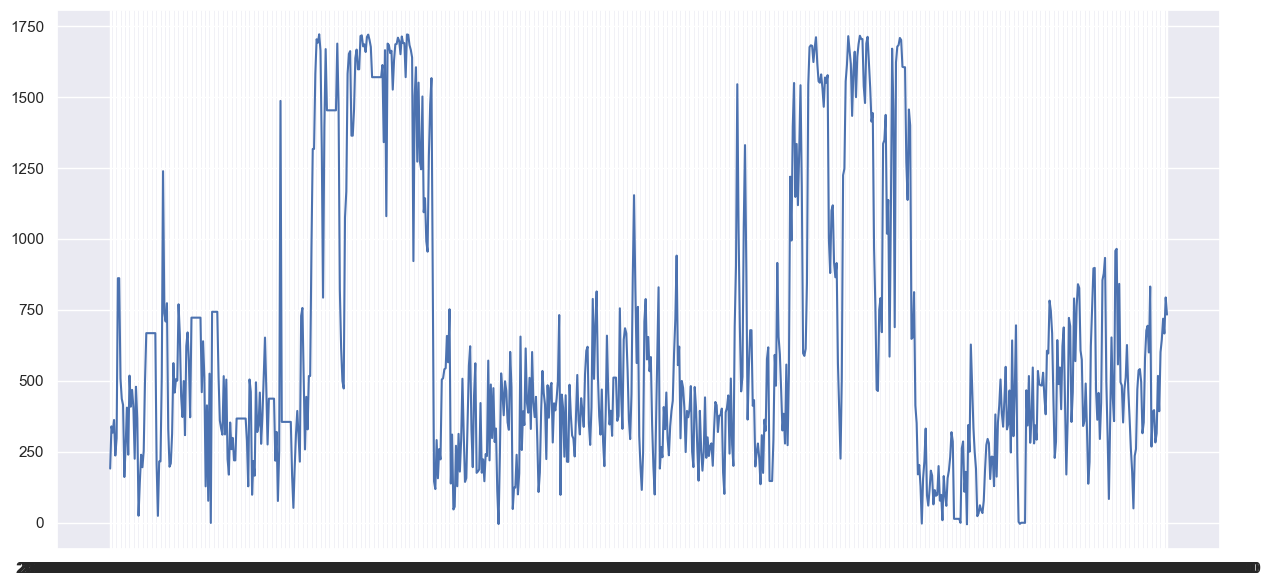

In [114]:
def forecast(model):
    # Forecast
    fitted, confint = model.predict(n_periods=15, return_conf_int=True)
    index_of_fc = pd.date_range(y_full_daily.index[-1], periods = 15, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(y_full_daily)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA - Forecast of power generation")
    plt.show()

forecast(pmdARIMA_model_d)

In [ ]:
#Plotting data
# daily_averages.daily_av.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
# daily_averages.windspeed.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
# plt.show()

## SARIMA (seasonal ARIMA)
- An extension to ARIMA -supports direct modeling of the seasonal component 
- Including seasonality and exogenous variables in a time series model can be extremely powerful.

In [98]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model_h = pm.auto_arima(y_full_hourly, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=24, #the frequncy of the annual cycle on the daily data
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

MemoryError: Unable to allocate 375. MiB for an array with shape (50, 50, 19680) and data type float64

In [190]:
# SARIMA_model_daily = pm.auto_arima(y_full_daily, seasonal=True, m=61, stepwise=True)

In [102]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model_d = pm.auto_arima(y_full_daily, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=61, # the frequncy of the annual cycle on the daily data
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

MemoryError: Unable to allocate 97.8 MiB for an array with shape (125, 125, 820) and data type float64

In [ ]:
forecast(SARIMA_model_d)

In [183]:
SARIMA_model_d.predict()

NameError: name 'SARIMA_model_d' is not defined

### Limitations with auto arima -when handling large dataset
- With the frequency and density of this data, there are multiple cycles/seasonal 
patterns.
- ARIMA has been seaid to only handle one seasonal component. 
- https://stackoverflow.com/questions/63438979/python-pmdarima-autoarima-does-not-work-with-large-data
- MemoryError: Unable to allocate 101. MiB for an array with shape (26, 26, 19680) and data type float64

# SARIMAX
- takes into account exogenous variables -external data
- exogenous factors are indirectly modeled 
- if included, the model will respond quicker than relying solely on the influence of lagging terms.

In [199]:
data = y_full_hourly
sarimax_hourly = SARIMAX(data)
sarimax_hourly_fit = sarimax_hourly.fit()
# specify training data
# The forecast() function takes a single parameter that specifies the number of out of 
# sample time steps to forecast, or assumes a one step forecast if no arguments are provided
# one step forecast
hourly_av['sarimax_hourly'] = sarimax_hourly_fit.predict()

C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


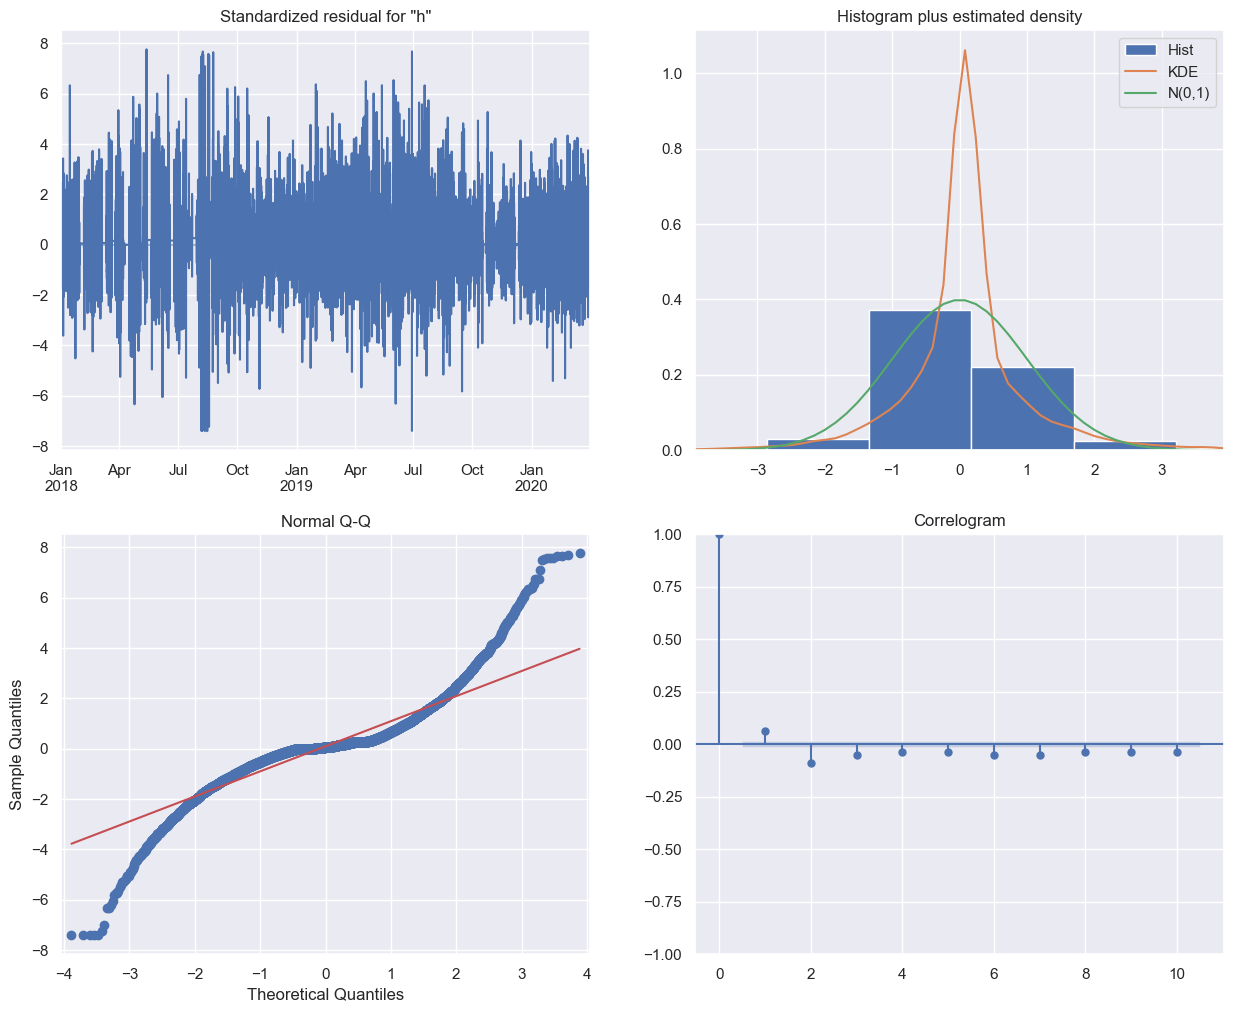

In [206]:
sarimax_hourly_fit.plot_diagnostics(figsize=(15,12))
plt.show()

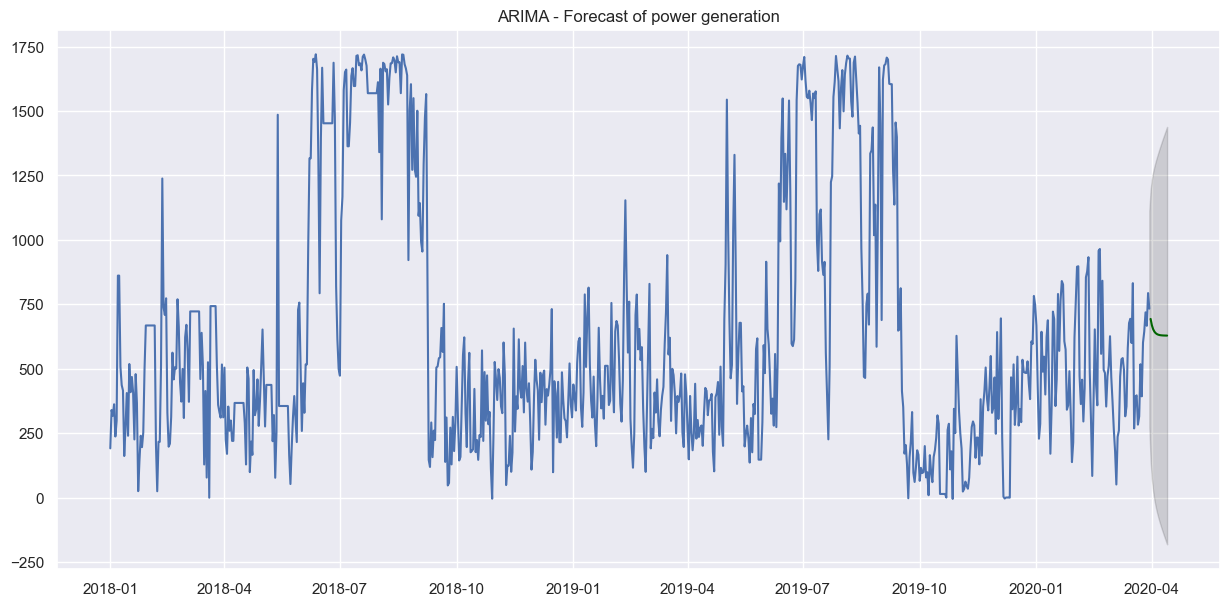

In [207]:
forecast(sarimax_hourly_fit)

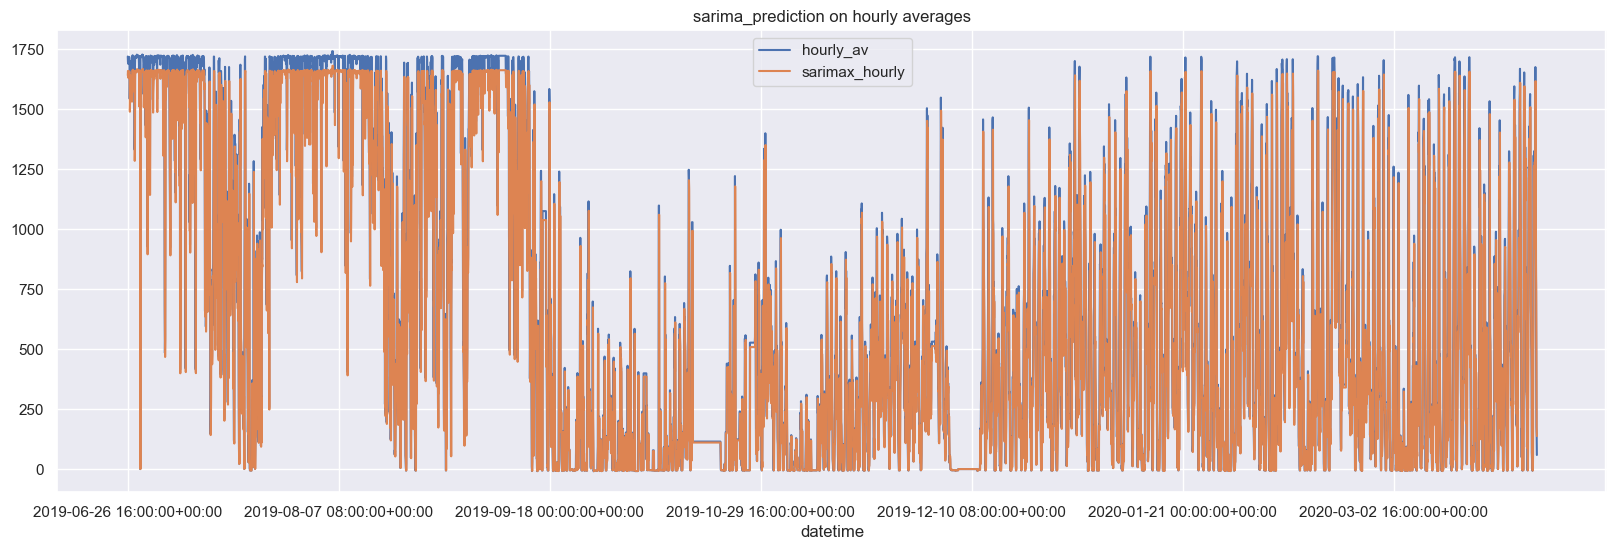

In [200]:
hourly_av[['hourly_av', 'sarimax_hourly']][13000:].plot(figsize = (20, 6)).set_title("sarima_prediction on hourly averages");

In [182]:
fitted, confint = sarimax_hourly.predict(n_periods=31, return_conf_int=True, exogenous=hourly_av[['windspeed']])
index_of_fc = pd.date_range(y_full_hourly.index[-1], periods = 31, freq='H', tz='utc')
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
y_full_hourly.index = pd.to_datetime(y_full_hourly.index)
X = y_full_hourly.index.append(index_of_fc)
plt.figure(figsize=(15,7))
plt.plot(X[18600:19680], y_full_hourly[18600:19680], c='blue')
plt.plot(X[19680:], fitted_series, color='red')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15);

TypeError: Model.predict() missing 1 required positional argument: 'params'

In [181]:
def sarimax_forecast(model, periods):
    # Forecast
    n_periods = periods

    fitted, confint = sarimax_hourly.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=hourly_av[['hourly_av']])
    index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='H')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    y_full_hourly.index = pd.to_datetime(y_full_hourly.index)
    X = y_full_hourly.index.append(index_of_fc)
    plt.figure(figsize=(15,7))
    plt.plot(X[18600:19680], y_full_hourly[18600:19680], c='blue')
    plt.plot(X[19680:], fitted_series, color='red')
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(sarimax_hourly, 48)

TypeError: Model.predict() missing 1 required positional argument: 'params'

In [191]:
data = y_full_daily
sarimax_daily = SARIMAX(data)
sarimax_daily_fit = sarimax_daily.fit()
# specify training data
# The forecast() function takes a single parameter that specifies the number of out of 
# sample time steps to forecast, or assumes a one step forecast if no arguments are provided
# one step forecast
daily_av['sarimax_daily'] = sarimax_daily_fit.predict()

C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\envs\final_project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


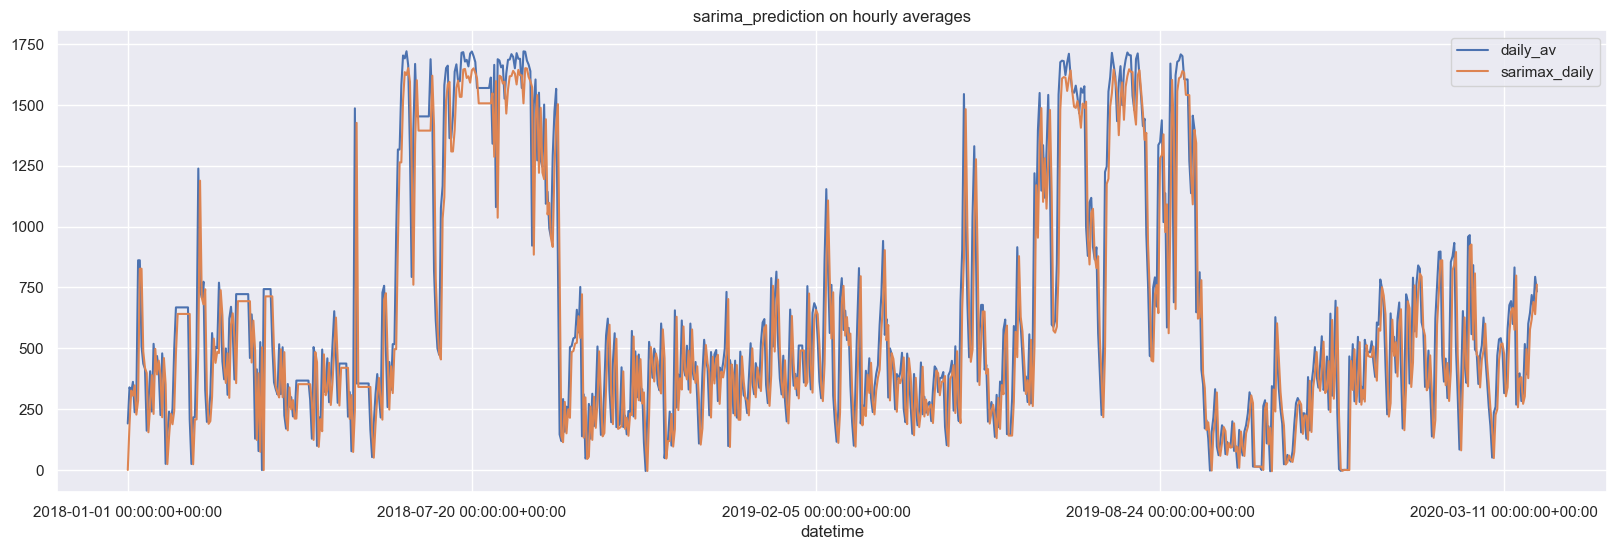

In [198]:
# Visualize the forecasts
daily_av[['daily_av', 'sarimax_daily']].plot(figsize = (20, 6)).set_title("sarima_prediction on daily averages");

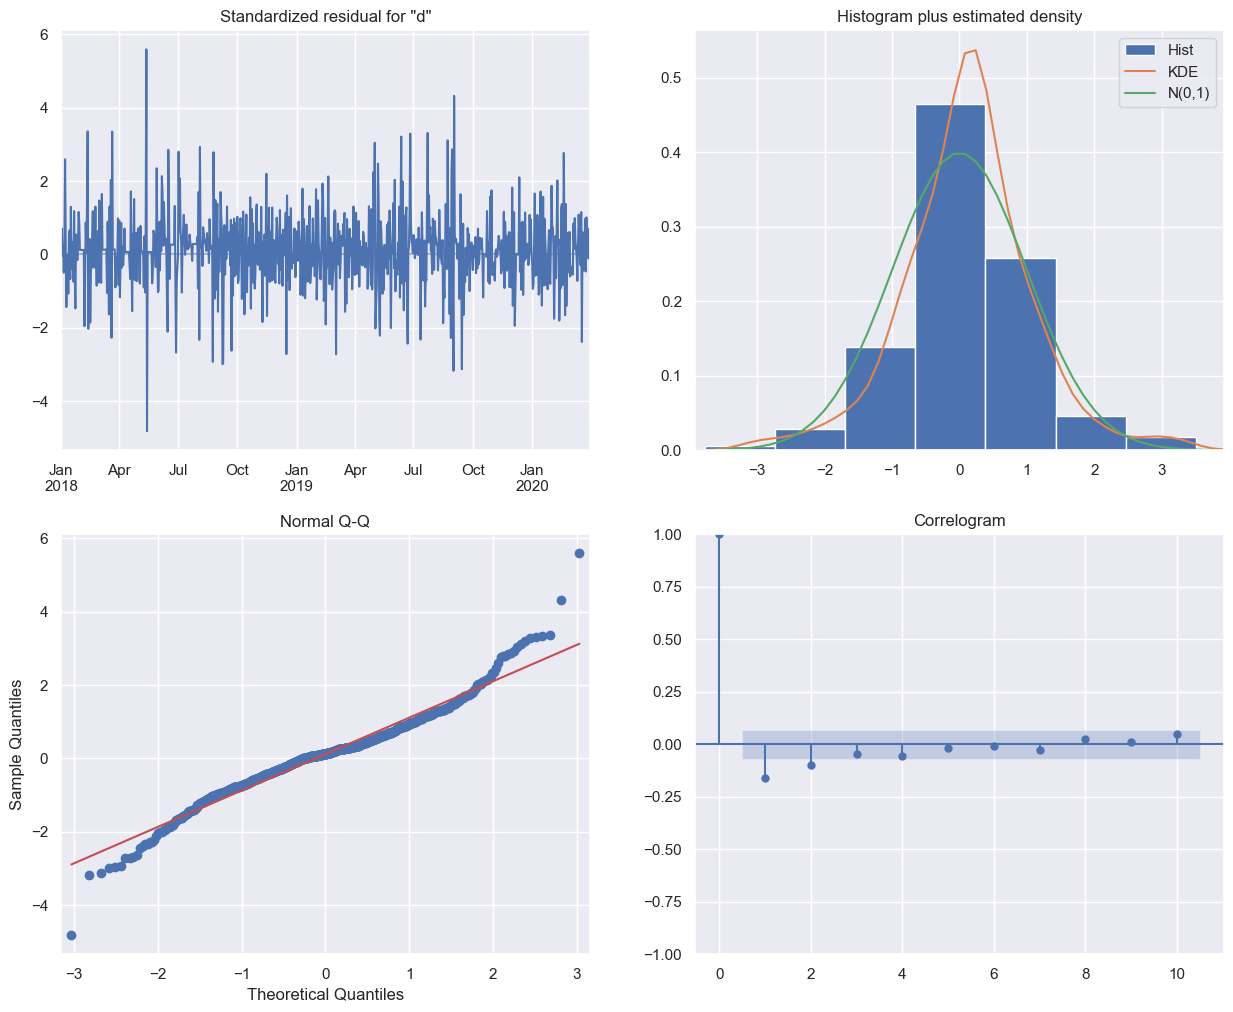

In [203]:
sarimax_daily_fit.plot_diagnostics(figsize=(15,12))
plt.show()

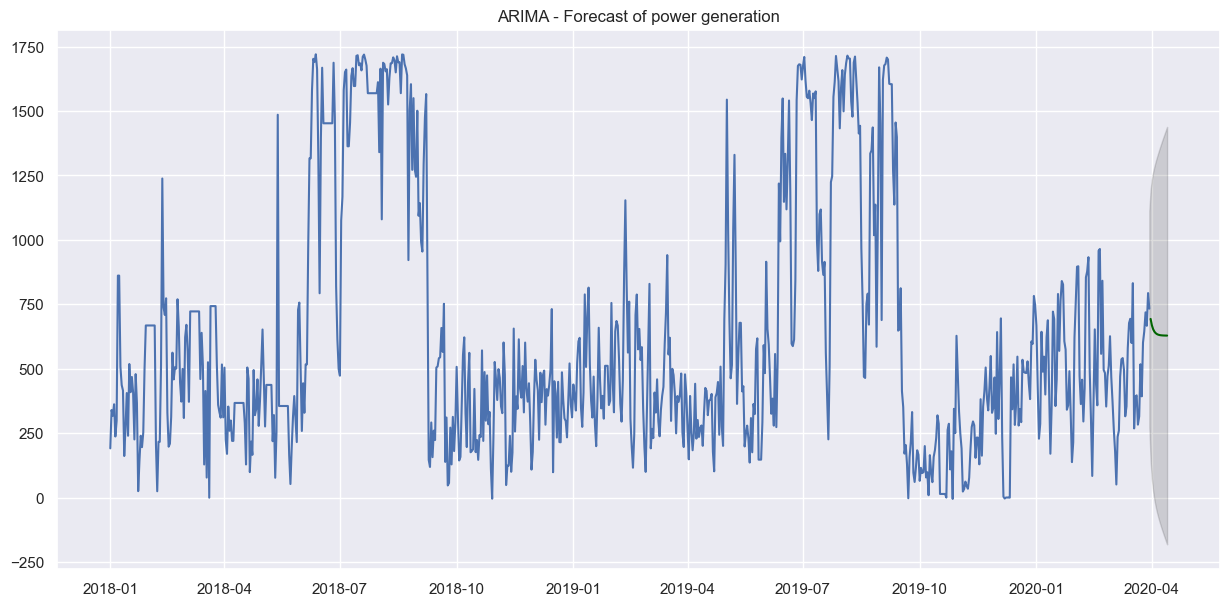

In [205]:
forecast(sarimax_daily_fit)

In [103]:
#adding exogenous variable
# SARIMAX Model
SARIMAX_model = pm.auto_arima(dailyly_av[['hourly_av']], exogenous=hourly_av[['windspeed']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

MemoryError: Unable to allocate 101. MiB for an array with shape (26, 26, 19680) and data type float64

## Next step
- The exercise gave me a good grasp on  AIMA model architectures, 
- the next step would now be to look into models that can handle multiple seasonalities like STS or Prophet LSTM and RNN deep learning models that are known to generate more accurate predictions.

## Links + Resources
- https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [217]:
hourly_av

,windspeed,hourly_av,arima_base_h,sarimax_hourly
datetime,,,,
2018-01-01 00:00:00+00:00,2.097677,-5.091432,0.000000,0.000000
2018-01-01 01:00:00+00:00,1.954781,-4.822549,-5.105553,-4.913614
2018-01-01 02:00:00+00:00,1.704621,-4.668977,-4.807257,-4.654122
2018-01-01 03:00:00+00:00,1.913003,-5.262396,-4.660243,-4.505914
2018-01-01 04:00:00+00:00,2.180540,-5.600275,-5.296145,-5.078608
...,...,...,...,...
2020-03-30 19:00:00+00:00,6.797400,763.009756,861.482658,854.444739
2020-03-30 20:00:00+00:00,5.944226,501.955794,756.051276,736.361788
2020-03-30 21:00:00+00:00,4.544032,176.391739,487.109481,484.425085


In [216]:
# Python
m_prophet = Prophet()
m_prophet.fit(y_full_hourly)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.